### Content Analysis
#### Joseph Denby

Load relevant packages and functions. 

In [2]:
import pandas as pd
import numpy as np
import feather

import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy
import lucem_illud
import nltk

import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
%matplotlib inline

In [3]:
def wordCounter(wordLst):
    wordCounts = {}
    for word in wordLst:
        #We usually need to normalize the case
        wLower = word.lower()
        if wLower in wordCounts:
            wordCounts[wLower] += 1
        else:
            wordCounts[wLower] = 1
    #convert to DataFrame
    countsForFrame = {'word' : [], 'count' : []}
    for w, c in wordCounts.items():
        countsForFrame['word'].append(w)
        countsForFrame['count'].append(c)
    return pd.DataFrame(countsForFrame)

Read in dataframes

In [19]:
ldpdf = feather.read_dataframe('utterances.feather')
ldpdf = ldpdf.drop(columns=['c_chat', 'order', 'line'])
ldpdf = ldpdf.dropna()

In [24]:
ldpdf.shape

(1267483, 3)

In [116]:
bookdf = pd.read_csv("bookdf.csv", index_col=0)
bookdf['tokens'] = bookdf['text'].apply(lambda x: nltk.word_tokenize(x))
bookdf['nltktext'] = bookdf['tokens'].apply(lambda x: nltk.Text(x))
bookdf[:10]

,author,text,title,tokens,nltktext
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, ``, Bark, ,, G...","(George, ’, s, mother, said, :, ``, Bark, ,, G..."
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...","(One, day, ,, Little, Sal, went, with, her, mo..."
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...","(Brown, Bear, ,, Brown, Bear, ,, What, do, you..."
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...","(Farmer, Brown, has, a, problem, ., His, cows,..."
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...","(We, were, all, sitting, around, the, big, kit..."
5,Don Freeman,Corduroy is a bear who once lived in the toy d...,Corduroy,"[Corduroy, is, a, bear, who, once, lived, in, ...","(Corduroy, is, a, bear, who, once, lived, in, ..."
6,H.A. Rey,This is George. He lived in Africa. He was a g...,Curious George,"[This, is, George, ., He, lived, in, Africa, ....","(This, is, George, ., He, lived, in, Africa, ...."
7,Sheila McGraw,A mother held her new baby and very slowly roc...,Love You Forever,"[A, mother, held, her, new, baby, and, very, s...","(A, mother, held, her, new, baby, and, very, s..."
8,Ruth Krauss,A little boy planted a carrot seed. His mother...,The Carrot Seed,"[A, little, boy, planted, a, carrot, seed, ., ...","(A, little, boy, planted, a, carrot, seed, ., ..."
9,Ezra Jack Keats,One winter morning Peter woke up and looked ou...,The snowy Day,"[One, winter, morning, Peter, woke, up, and, l...","(One, winter, morning, Peter, woke, up, and, l..."


Compute stopword list based on corpus frequency and create tokenized and normalized nltk sentence columns.

In [5]:
alltokens = bookdf['tokens'].sum()

#all words sorted by frequency
allcountedWords = wordCounter(alltokens)
allcountedWords.sort_values('count', ascending=False, inplace=True)

stop_words_freq = []
countsDict = {}
for word in alltokens:
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)
word_counts[:100]
for word, count in word_counts:
    if word == 'little':
        break
    else:
        stop_words_freq.append(word)

In [7]:
bookdf['tokenized_sents'] = bookdf['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
bookdf['normalized_sents'] = bookdf['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = stop_words_freq, stemmer = None) for s in x])
bookdf[:5]

,author,text,title,tokens,nltktext,tokenized_sents,normalized_sents
0,Jules Feiffer,"George’s mother said: ""Bark, George."" George w...","Bark, George","[George, ’, s, mother, said, :, ``, Bark, ,, G...","(George, ’, s, mother, said, :, ``, Bark, ,, G...","[[George, ’, s, mother, said, :, ``, Bark, ,, ...","[[george, mother, bark, george], [george, went..."
1,Robert McCloskey,"One day, Little Sal went with her mother to Bl...",Blueberries for Sal,"[One, day, ,, Little, Sal, went, with, her, mo...","(One, day, ,, Little, Sal, went, with, her, mo...","[[One, day, ,, Little, Sal, went, with, her, m...","[[one, day, little, sal, went, mother, blueber..."
2,Bill Martin Jr,"Brown Bear, Brown Bear, What do you see? I see...","Brown Bear, Brown Bear, What Do You See?","[Brown, Bear, ,, Brown, Bear, ,, What, do, you...","(Brown, Bear, ,, Brown, Bear, ,, What, do, you...","[[Brown, Bear, ,, Brown, Bear, ,, What, do, yo...","[[brown, bear, brown, bear, what, do, see], [i..."
3,Doreen Cronin,Farmer Brown has a problem. His cows like to t...,"Click, Clack, Moo Cows that Type","[Farmer, Brown, has, a, problem, ., His, cows,...","(Farmer, Brown, has, a, problem, ., His, cows,...","[[Farmer, Brown, has, a, problem, .], [His, co...","[[farmer, brown, has, problem], [cows, type], ..."
4,Judi Barrett,We were all sitting around the big kitchen tab...,Cloudy With a Chance of Meatballs,"[We, were, all, sitting, around, the, big, kit...","(We, were, all, sitting, around, the, big, kit...","[[We, were, all, sitting, around, the, big, ki...","[[we, were, sitting, around, big, kitchen, tab..."


Now, create a tf-idf matrix. This is a sparse matrix with each row being a document (book) and each column a word appearing in the corpus.

First, a vectorizer that creates a count matrix (each field is the number of times a word appears in a document).

In [117]:
#First it needs to be initialized
bookCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
bookgroupVects = bookCountVectorizer.fit_transform(bookdf['text'])

In [16]:
bookgroupVects.shape

(100, 5577)

In [49]:
bookCountVectorizer.vocabulary_.get("")

Now, compute the tf-idf matrix. This assigns a score (tf-idf) to each word in each document according to its 'tellingness.' Each score is an indication of the word's importance within a document weighted by its relative presence across the entire corpus.

In [57]:

#initialize
bookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words_freq, norm='l2')
#train
bookgroupTFVects = bookTFVectorizer.fit_transform(bookdf['text'])

In [62]:
list(zip(bookTFVectorizer.vocabulary_.keys(), bookgroupTFVects.data))[:20]

[('george', 0.8250452029628907),
 ('mother', 0.0806859374239559),
 ('bark', 0.30346153103359197),
 ('went', 0.10025854047243683),
 ('meow', 0.07409044053577216),
 ('no', 0.02782304744964275),
 ('cats', 0.023572720084654025),
 ('go', 0.053296564657065615),
 ('dogs', 0.06539709675813102),
 ('arf', 0.12138461241343679),
 ('now', 0.02875583332681148),
 ('quack', 0.1481808810715443),
 ('ducks', 0.02607259267803477),
 ('oink', 0.07821777803410432),
 ('pigs', 0.02607259267803477),
 ('moo', 0.055692561019956906),
 ('took', 0.013447656237325984),
 ('vet', 0.2124230717235144),
 ('ll', 0.011014437746450794),
 ('soon', 0.014532100367612747)]

In [123]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 4).fit(bookgroupTFVects.toarray())
reduced_data = pca.transform(bookgroupTFVects.toarray())
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

In [122]:
redu

array([[-6.92441597e-04, -3.10051955e-04, -1.73959139e-03, ...,
        -3.74375126e-04, -1.84840795e-03, -8.40431720e-05],
       [ 6.11263516e-04,  1.76518196e-04, -5.11822857e-04, ...,
        -5.01952367e-04,  3.72336919e-03, -1.87272269e-04]])

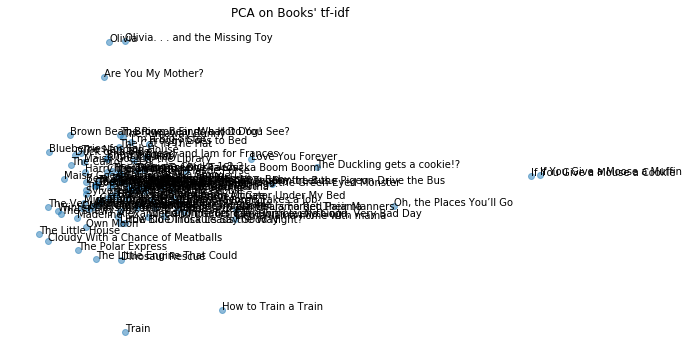

In [127]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 2], reduced_data[:, 3], alpha = 0.5)
for i, booktitle in enumerate(booktitles):
    ax.annotate(booktitle, (reduced_data[i,2], reduced_data[i,3]))
plt.xticks(())
plt.yticks(())
plt.title('PCA on Books\' tf-idf')
plt.show()

Based on above filtering, most books have similar tf-idf vectors except for a few. Upon closer inspection, these books appear to use idiosyncratic words frequently (e.g., George, Llama). I can try adding these to the stop words list to see how this changes the PCA.

In [96]:
new_stop_words = stop_words_freq[:] + ['george', 'llama']
#initialize
newbookTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=.5, min_df=3, stop_words=new_stop_words, norm='l2')
#train
newbookgroupTFVects = newbookTFVectorizer.fit_transform(bookdf['text'])

In general – can tweak a few parameters w.r.t. tfidfvectorizer: max_df, min_df, stop_words.
Could also experiment with different stemming / lemmatization pre-processing.

In [129]:
newpca = PCA(n_components = 10).fit(newbookgroupTFVects.toarray())
newreduced_data = newpca.transform(newbookgroupTFVects.toarray())
components = newpca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
booktitles = bookdf['title']
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]

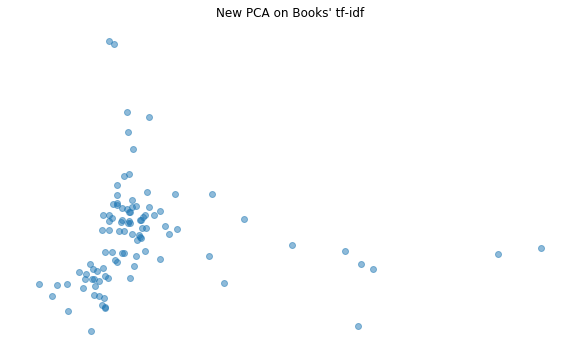

In [103]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(newreduced_data[:, 0], newreduced_data[:, 1], alpha = 0.5)
#for i, booktitle in enumerate(booktitles):
 #   ax.annotate(booktitle, (newreduced_data[i,0], newreduced_data[i,1]))
plt.xticks(())
plt.yticks(())
plt.title('New PCA on Books\' tf-idf')
plt.show()

Clustering algorithm:

In [111]:
numCategories = 3

In [112]:
bookKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
bookKM.fit(newbookgroupTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

This allows us to visualize the top 10 words per cluster:

In [128]:
terms = bookTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = bookKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 any
 eve
 along
 babushka
 become
 already
 across
 arrangement
 battered
 dearest


Cluster 1:
 elves
 due
 bumps
 claimed
 backward
 enters
 businesses
 dragon
 approached
 examine


Cluster 2:
 chopping
 choking
 ceilings
 charlie
 battered
 bumps
 bathtub
 counter
 expecting
 chops




Here we can reduce the tf-idf matrix using PCA in order to make visualization easier.

In [114]:
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in bookKM.labels_]

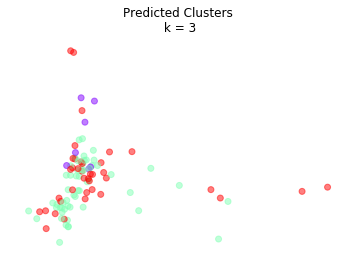

In [115]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(newreduced_data[:, 0], newreduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()